In [1]:
import pandas as pd
# %matplotlib inline
from keras.models import load_model
from keras import backend as K
import numpy as np
from sklearn.metrics import roc_curve, auc

Using Theano backend.


In [2]:
history = pd.read_pickle('history2.h5')

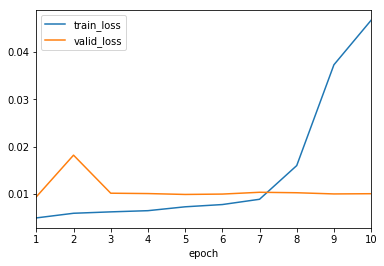

In [3]:
history.plot(y=['train_loss', 'valid_loss'], x='epoch')

In [4]:
def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) +
                  (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

model = load_model('first_try.h5', custom_objects={'contrastive_loss': contrastive_loss})

In [5]:
test_df = pd.read_pickle('test.h5')

In [6]:
len(test_df)

907256

In [8]:
def generate_batch(x_left, x_right, y, size):
    while True:
        for i in xrange(0, len(x_left), size):
            x_left_b   = x_left[i:i+size]
            x_right_b  = x_right[i:i+size]
            y_b        = y[i:i+size]

            x_left_b   = np.array([np.array(row) for row in x_left_b])
            x_right_b  = np.array([np.array(row) for row in x_right_b])

            yield ([x_left_b, x_right_b], y_b)

In [9]:
batch_s = 200
batch_total = int(round((1.0*len(test_df))/batch_s))
x_left_test  = test_df.vec1.values
x_right_test = test_df.vec2.values
y_test       = test_df.is_duplicate.values

y_pred = model.predict_generator(generate_batch(x_left_test, x_right_test, y_test, batch_s),
                                 batch_total, 
                                 verbose=1)

KeyboardInterrupt: 

In [ ]:
np.save('predictions.h5', y_pred)

In [10]:
y_pred = np.load('predictions.h5.npy')
y_pred = np.reshape(y_pred, (y_pred.shape[0],))

In [34]:
fp = 0
fa = 0
eer = 0
fp_r = []
fa_r = []
thresholds = np.linspace(0.0, 1.0, num=20)

y_pred_thresh = []

for t in thresholds:
    for y in y_pred:
        if y < t:
            y_pred_thresh.append(0)
        else:
            y_pred_thresh.append(1)

    for y in zip(y_pred_thresh, y_test[:907200]):
        if y[1] == 1 and y[0] == 0:
            fp+=1
        if y[1] == 0 and y[0] == 1:
            fa+=1
    fp_r.append(100*(fp*1.0)/len(y_test))
    fa_r.append(100*(fa*1.0)/len(y_test))
    fp = 0
    fa = 0
    y_pred_thresh = []
    

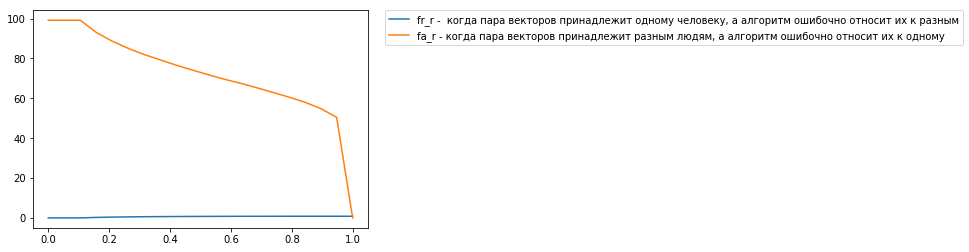

EER - 0.838568913284


In [36]:
import matplotlib.pyplot as plt
plt.plot(thresholds, fp_r, label=u'fr_r -  когда пара векторов принадлежит одному человеку, а алгоритм ошибочно относит их к разным')
plt.plot(thresholds, fa_r, label=u'fa_r - когда пара векторов принадлежит разным людям, а алгоритм ошибочно относит их к одному')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

from shapely.geometry import LineString

line1 = LineString(zip(thresholds, fp_r))
line2 = LineString(zip(thresholds, fa_r))

print('EER - {}'.format(line1.intersection(line2).y))